In [1]:
pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 9.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime
from nltk.corpus import stopwords
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer as wnl
from unidecode import unidecode
from string import punctuation

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/scrapped-lyrics-from-6-genres/artists-data.csv
/kaggle/input/scrapped-lyrics-from-6-genres/lyrics-data.csv


Load the csv files into Pandas DataFrames

In [3]:
artist_df = pd.read_csv("/kaggle/input/scrapped-lyrics-from-6-genres/artists-data.csv")
lyrics_df = pd.read_csv("/kaggle/input/scrapped-lyrics-from-6-genres/lyrics-data.csv")

Take a look at artist_df

In [4]:
artist_df.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


Take a look at lyrics_df

In [5]:
lyrics_df.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


# Processing of Lyric DataFrame

**Perform text cleaning on the lyrics**

In [6]:
def clean_text(words): 
    # skip NaN or non-string
    if not isinstance(words, str):  
        return ""
    # lowercase the text
    words = words.lower()
    # fix encodings and punctuation
    words = unidecode(words)
    # fix html tags
    words = re.sub('<[^<]+?>','', words)
    # remove numbers
    words = ''.join(c for c in words if not c.isdigit())
    # remove URL's
    words = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', words)
    # remove punctuations
    words = ''.join(c for c in words if c not in punctuation)
    
    return word_tokenize(words)

In [7]:
lyrics_df['Lyric'].convert_dtypes()

0         Tudo o que eu quero nessa vida,
Toda vida, é
É...
1         Meu coração
Sem direção
Voando só por voar
Sem...
2         É de babaixá!
É de balacubaca!
É de babaixá!
É...
3         Quando a chuva passar

Pra quê falar
Se você n...
4         A minha sorte grande foi você cair do céu
Minh...
                                ...                        
379926    Chorus
Here we stand waiting on the plain
Dark...
379927    I nearly disappeared into the mouth of a croco...
379928    Amambuka, amambuka azothengisa izwe lakithi, i...
379929    Sweat in the heat for days on end
waiting for ...
379930    Here we stand on the edge of the day
Faces mel...
Name: Lyric, Length: 379931, dtype: string

In [8]:
start_time = datetime.now()
lyrics_df['Lyric_Clean'] = lyrics_df.apply(lambda row : clean_text(row['Lyric']), axis = 1)
end_time = datetime.now()
print('Lyric Cleaning Time: {}'.format(end_time - start_time))

Lyric Cleaning Time: 0:04:53.946252


**Remove stopwords (a, the, is, etc.)**

Identify top five languages in the dataset, for simplicity. 

In [9]:
lyrics_df.groupby('language').size().sort_values(ascending=False).nlargest(5).reset_index(name='Count')

,language,Count
0,en,191814
1,pt,157393
2,es,9917
3,rw,1679
4,it,1432


Let's make sure that the NLTK package has stopwords for the top five languages in our dataset. 

In [10]:
print(stopwords.fileids())

['albanian', 'arabic', 'azerbaijani', 'basque', 'belarusian', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'tamil', 'turkish']


Looks like NLTK has stopwords for English (en), Portuguese (pt), Spanish (es), and Italian (it). Let's make a list of those stopwords. 

In [11]:
top_lang_stopwords = [stopwords.words('english'), stopwords.words('portuguese'), stopwords.words('spanish'), stopwords.words('italian')]

In [12]:
def remove_stop_words(words, stopwords): 
    new_words = list()

    for word in words: 
        if word not in stopwords: 
            new_words.append(word)

    return_words = ' '.join(new_words)
    return return_words

In [13]:
start_time = datetime.now()

lyrics_df['Lyric_Clean'] = lyrics_df.apply(lambda row : remove_stop_words(row['Lyric_Clean'], top_lang_stopwords), axis = 1)

end_time = datetime.now()
print('Stopword removal time: {}'.format(end_time - start_time))

Stopword removal time: 0:00:14.169036


**Perform Lemmatization on the cleaned lyrics**

Lemmatization reduces each word to its root form (ex: happily --> happy), thereby reducing dimensionality of the data. We'll use [NLTK's lemmatization library](https://www.nltk.org/api/nltk.stem.wordnet.html) to do this. 

In [14]:
start_time = datetime.now()

lyrics_df['Lyric_Clean'] = lyrics_df.apply(lambda row : wnl().lemmatize(row['Lyric_Clean']), axis = 1)

end_time = datetime.now()
print('Lyric lemmatization time: {}'.format(end_time - start_time))

Lyric lemmatization time: 0:00:06.043902


In [15]:
lyrics_df.head()

,ALink,SName,SLink,Lyric,language,Lyric_Clean
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt,tudo o que eu quero nessa vida toda vida e e a...
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt,meu coracao sem direcao voando so por voar sem...
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt,e de babaixa e de balacubaca e de babaixa e de...
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt,quando a chuva passar pra que falar se voce na...
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt,a minha sorte grande foi voce cair do ceu minh...


# Processing of the Artist DataFrame

Clean up the artist_df DataFrame and create a list of all the genres (delimited by ;)

In [16]:
# def genre_split(column_values):
#     # skip NaN or non-string
#     if not isinstance(column_values, str):  
#         return ""
#     column_values = column_values.split(";")
#     column_values = [value.strip().lower() for value in column_values]
#     return column_values

In [17]:
# artist_df['Genres'] = artist_df['Genres'].apply(genre_split)

Let's explore the genres in the artist_df (top 10)

In [18]:
pd.set_option('display.max_rows', None)
artist_df.groupby('Genres').size().reset_index(name='count').nlargest(15, columns='count')

,Genres,count
315,Gospel/Religioso,244
1492,Sertanejo,97
255,Funk Carioca,61
599,Indie,53
212,Forró,49
873,Pop,49
1230,Rock,49
1127,Rap,46
1139,Rap; Hip Hop,43
506,Heavy Metal,42


In [19]:
artist_df = artist_df.replace({'Genres': ['Rap; Hip Hop']}, {'Genres': ['Rap']})
artist_df = artist_df.replace({'Genres': ['Hip Hop; Rap']}, {'Genres': ['Hip Hop']})
genre_list = artist_df.groupby('Genres').size().reset_index(name='count').nlargest(15, columns='count')['Genres'].tolist()
genre_list

['Gospel/Religioso',
 'Sertanejo',
 'Rap',
 'Funk Carioca',
 'Indie',
 'Forró',
 'Pop',
 'Rock',
 'Hip Hop',
 'Heavy Metal',
 'MPB',
 'Samba',
 'Trilha Sonora',
 'Country',
 'Reggae']

We will use the above 10 most popular genres in the dataset to group the genres in the artist_df. Anything that does not contain these genres will be put into the 'other' bucket. The first listed genre in the list will be prioritized (ex: pop; rock; gospel/religioso --> pop). 

In [20]:
# Form a Genre Group column in the artist_df that will host the group that each genre/group belongs to 
# Extract the first word from the Genres column 
artist_df['Genre_Group'] = artist_df['Genres'].str.extract(r'^([\w\s]+?)(?:;|$)', expand=False)
artist_df.head(15)

,Artist,Genres,Songs,Popularity,Link,Genre_Group
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/,Pop
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/,Axé
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/,Axé
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/,Axé
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/,Pop
5,Harmonia do Samba,Axé; Samba; Pagode,237.0,0.9,/harmonia-do-samba/,Axé
6,Ara Ketu,Axé; Pop,139.0,1.5,/ara-ketu/,Axé
7,Daniela Mercury,MPB; Axé,230.0,1.4,/daniela-mercury/,MPB
8,Olodum,Axé,74.0,1.3,/olodum/,Axé
9,Netinho,Axé,204.0,2.0,/netinho/,Axé


In [21]:
def match_top_genre(genres, genre_list):
    if pd.isna(genres):
        return "Other"
    for g in genres.split(";"):
        g = g.strip()
        if g in genre_list:
            return g   # preference for first match found
    return "Other"  # if there is no match, then label as "Other"

In [22]:
artist_df['Genre_Group'] = artist_df['Genres'].apply(lambda x: match_top_genre(x, genre_list))
artist_df.groupby('Genre_Group').size().nlargest(16)


Genre_Group
Other               804
Rock                507
Gospel/Religioso    503
Pop                 426
Sertanejo           250
Indie               239
Rap                 192
Trilha Sonora       180
Heavy Metal         177
Samba               157
Hip Hop             156
Funk Carioca        152
MPB                 150
Forró               121
Reggae               91
Country              63
dtype: int64

Merge the Songs and Artist DataFrames

In [23]:
artist_lyrics_df = pd.merge(artist_df, lyrics_df[['ALink', 'SName', 'Lyric', 'Lyric_Clean']], left_on="Link", right_on="ALink")
artist_lyrics_df.head()

,Artist,Genres,Songs,Popularity,Link,Genre_Group,ALink,SName,Lyric,Lyric_Clean
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/,Pop,/ivete-sangalo/,Arerê,"Tudo o que eu quero nessa vida,\nToda vida, é\...",tudo o que eu quero nessa vida toda vida e e a...
1,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/,Pop,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,Meu coração\nSem direção\nVoando só por voar\n...,meu coracao sem direcao voando so por voar sem...
2,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/,Pop,/ivete-sangalo/,Céu da Boca,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,e de babaixa e de balacubaca e de babaixa e de...
3,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/,Pop,/ivete-sangalo/,Quando A Chuva Passar,Quando a chuva passar\n\nPra quê falar\nSe voc...,quando a chuva passar pra que falar se voce na...
4,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/,Pop,/ivete-sangalo/,Sorte Grande,A minha sorte grande foi você cair do céu\nMin...,a minha sorte grande foi voce cair do ceu minh...


Dataframe stats: 

In [24]:
artist_count = artist_df['Artist'].count()
song_count = lyrics_df['SName'].count()
artist_song_count = artist_lyrics_df['SName'].count()
print(f'Number of rows in artist_df: {artist_count}')
print(f'Number of rows in lyrics_df: {song_count}')
print(f'Number of rows after joining artist and songs df: {artist_song_count}')

Number of rows in artist_df: 4167
Number of rows in lyrics_df: 379928
Number of rows after joining artist and songs df: 378985


# Evaluation

Vectorize the lyrics and encode the genres

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert lyrics to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(artist_lyrics_df['Lyric_Clean'])

from sklearn.preprocessing import LabelEncoder

# Convert Genre_Group into integers
le = LabelEncoder()
y = le.fit_transform(artist_lyrics_df['Genre_Group'])



Split the dataset into training and testing datasets

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


Train the model using logistic regression

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # hyperparameter search

clf = LogisticRegression(solver='saga', max_iter=2000)

grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Best hyperparameter C:", grid.best_params_['C'])
print("Best cross-validated accuracy:", grid.best_score_)



Best hyperparameter C: 1
Best cross-validated accuracy: 0.4686375154698135


In [28]:
best_model = grid.best_estimator_
y_test_pred = best_model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

print("Test set accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

Test set accuracy: 0.468014818411137
                  precision    recall  f1-score   support

         Country       0.49      0.24      0.32      2180
           Forró       0.49      0.37      0.42      2951
    Funk Carioca       0.66      0.53      0.59      1042
Gospel/Religioso       0.82      0.83      0.82     10282
     Heavy Metal       0.61      0.52      0.56      4718
         Hip Hop       0.53      0.35      0.42      3757
           Indie       0.36      0.14      0.20      4614
             MPB       0.38      0.43      0.41      4850
           Other       0.36      0.42      0.39     17358
             Pop       0.37      0.33      0.35      9723
             Rap       0.62      0.57      0.59      3826
          Reggae       0.70      0.17      0.27      1359
            Rock       0.37      0.52      0.43     14644
           Samba       0.42      0.35      0.38      3742
       Sertanejo       0.52      0.73      0.60      7296
   Trilha Sonora       0.41      0

# Results

Plot the results

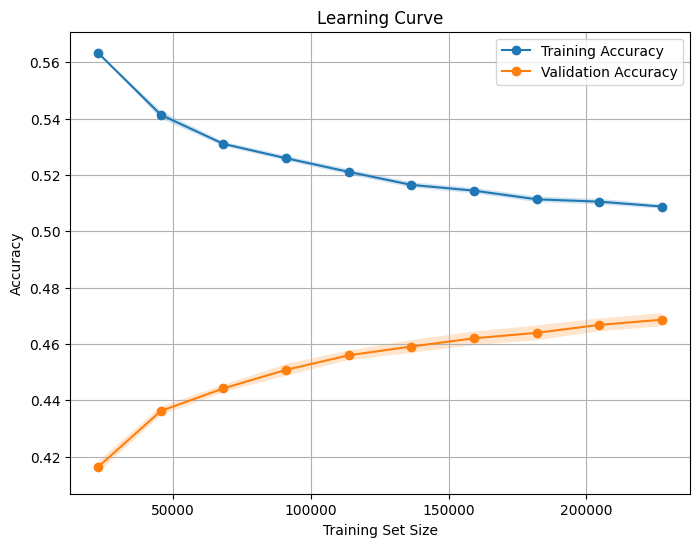

In [29]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


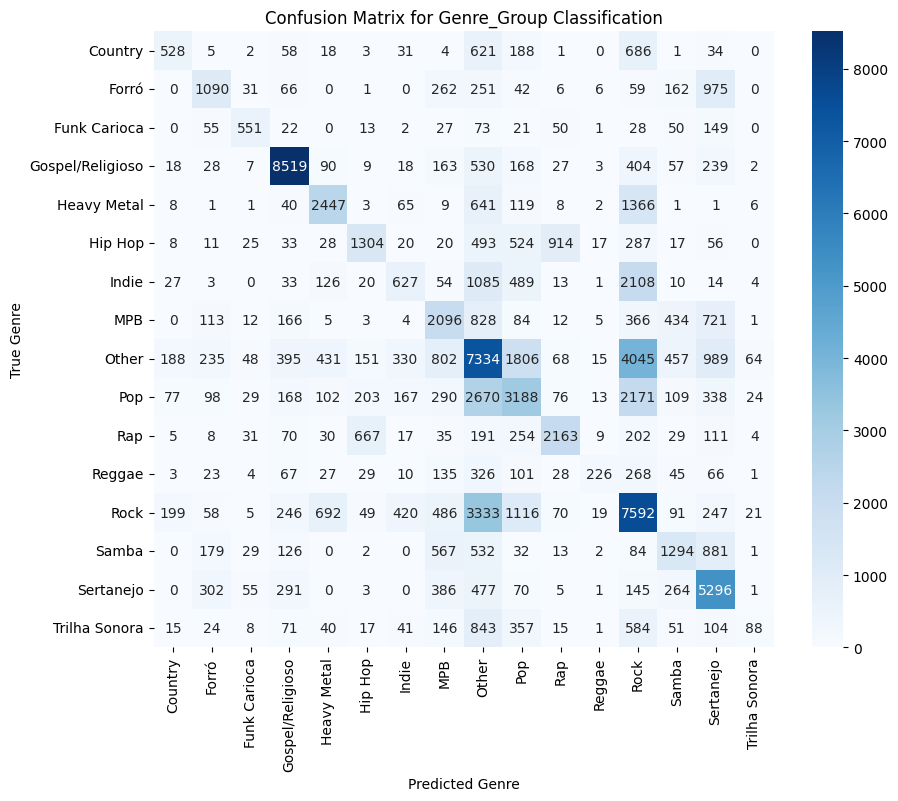

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues"
)
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.title("Confusion Matrix for Genre_Group Classification")
plt.show()
